In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import urllib.request
import time

In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
out_classes = [
    "axe", "airplane", "apple", "banana", "baseball", "baseball bat", "birthday cake",
    "book", "bucket", "bus", "candle", "camera", "car", "cell phone", "cloud",
    "coffee cup", "crown", "dolphin", "donut", "dumbbell", "envelope", "eye",
    "eyeglasses", "finger", "fish", "flashlight", "flower", "fork", "golf club",
    "hammer", "hand", "headphones", "hot air balloon", "hourglass", "ice cream",
    "key", "knife", "ladder", "leaf", "light bulb", "lightning", "mountain",
    "mushroom", "octagon", "pencil", "pliers", "screwdriver", "see saw", "star",
    "sword", "syringe", "tooth", "toothbrush", "traffic light", "t-shirt", "umbrella",
    "vase", "windmill", "wine glass", "zigzag"
]


In [15]:
import os
import urllib.request
import urllib.parse
def obtain_dataset():
    if not os.path.exists("dataset"):
        os.mkdir("dataset")

    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

    for cls in out_classes:
        target_file = f"dataset/{cls}.npy"

        if os.path.exists(target_file):
            print(f"File {target_file} already exists, skipping...")
            continue

        encoded_cls = urllib.parse.quote(cls)  # Proper URL encoding
        url = base_url + encoded_cls + ".npy"
        print(f"Downloading {url} ...")
        urllib.request.urlretrieve(url, target_file)


In [16]:
obtain_dataset()

File dataset/axe.npy already exists, skipping...
File dataset/airplane.npy already exists, skipping...
File dataset/apple.npy already exists, skipping...
File dataset/banana.npy already exists, skipping...
File dataset/baseball.npy already exists, skipping...


In [9]:
class DoodleDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.float32) / 255.0
        if self.transform:
            image = self.transform(image)
        else:
            # Add channel dimension and convert to tensor
            image = torch.tensor(image).unsqueeze(0)

        label = self.labels[idx]
        return image, label

In [12]:
def load_dataset():
  ## Initialize variables
  X = np.empty([0, 784])
  Y = np.empty([0])
  images_per_class = 12000
  test_set_size = 10000

  print("Loading dataset...")
  for i in tqdm(range(0, len(out_classes))):
    imgs = np.load(f"dataset/{out_classes[i]}.npy")
    imgs = imgs[0:images_per_class, :]
    labels = np.full(images_per_class, i)
    X = np.concatenate((X, imgs), axis=0)
    Y = np.concatenate((Y, labels), axis=0)
    del imgs

  print("Randomizing and splitting dataset...")
  np.random.seed(1)
  order = np.random.permutation(Y.shape[0])
  X = X[order, :]
  Y = Y[order]

  X_test = X[0:test_set_size, :]
  Y_test = Y[0:test_set_size]
  X_train = X[test_set_size:X.shape[0], :]
  Y_train = Y[test_set_size:Y.shape[0]]

  return X_train, Y_train, X_test, Y_test

In [18]:
X_train, Y_train, X_test, Y_test = load_dataset()

Loading dataset...


100%|██████████| 60/60 [01:33<00:00,  1.56s/it]


Randomizing and splitting dataset...


In [19]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape: (710000, 784)
Y_train shape: (710000,)
X_test shape:  (10000, 784)
Y_test shape:  (10000,)


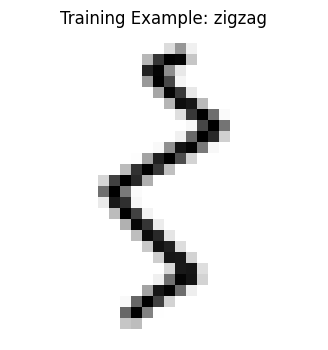

In [21]:
def visualize_image(index, X, Y, title=None):
    img = X[index].reshape(28, 28)
    class_name = out_classes[int(Y[index])]
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray_r')
    if title:
        plt.title(f"{title}: {class_name}")
    else:
        plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()
visualize_image(850, X_train, Y_train, "Training Example")

In [30]:
train_transform = transforms.Compose([
    transforms.Pad(2, fill=0),
    transforms.ToTensor(),
])
train_dataset = DoodleDataset(
    X_train,
    Y_train.astype(np.int64),
    transform=None
)
test_dataset = DoodleDataset(
    X_test,
    Y_test.astype(np.int64),
    transform=None
)

In [31]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [32]:
images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch label shape: {labels.shape}")


Batch image shape: torch.Size([128, 1, 28, 28])
Batch label shape: torch.Size([128])


In [33]:
class DoodleClassifier(nn.Module):
    def __init__(self, num_classes=60):
        super(DoodleClassifier, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(400, 120)  # 5x5x16 = 400
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Pad input to 32x32
        x = F.pad(x, (2, 2, 2, 2))

        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Flatten
        x = x.view(-1, 400)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [34]:
model = DoodleClassifier(num_classes=len(out_classes)).to(device)
print(model)

DoodleClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=60, bias=True)
)


In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")

Number of trainable parameters: 66000


In [36]:
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader)
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        pbar.set_description(f'Epoch {epoch} | Loss: {running_loss/(batch_idx+1):.4f} | Acc: {100.*correct/total:.2f}%')

    train_loss = running_loss / len(loader)
    train_acc = 100. * correct / total

    return train_loss, train_acc

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Save predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss = running_loss / len(loader)
    test_acc = 100. * correct / total

    return test_loss, test_acc, all_preds, all_targets

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 15

In [38]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
start_time = time.time()

In [39]:
print("Starting training...")
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate on test set every 5 epochs or on the last epoch
    if epoch % 5 == 0 or epoch == num_epochs:
        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    else:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")

test_loss, test_acc, all_preds, all_targets = evaluate(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

torch.save(model.state_dict(), "doodle_model_pytorch.pth")
print("Model saved successfully!")

Starting training...


Epoch 1 | Loss: 1.0189 | Acc: 73.98%: 100%|██████████| 5547/5547 [00:48<00:00, 115.22it/s]


Epoch 1 | Train Loss: 1.0189 | Train Acc: 73.98%


Epoch 2 | Loss: 0.7239 | Acc: 81.29%: 100%|██████████| 5547/5547 [00:47<00:00, 116.63it/s]


Epoch 2 | Train Loss: 0.7239 | Train Acc: 81.29%


Epoch 3 | Loss: 0.6635 | Acc: 82.76%: 100%|██████████| 5547/5547 [00:46<00:00, 120.37it/s]


Epoch 3 | Train Loss: 0.6635 | Train Acc: 82.76%


Epoch 4 | Loss: 0.6319 | Acc: 83.53%: 100%|██████████| 5547/5547 [00:45<00:00, 120.67it/s]


Epoch 4 | Train Loss: 0.6319 | Train Acc: 83.53%


Epoch 5 | Loss: 0.6108 | Acc: 84.02%: 100%|██████████| 5547/5547 [00:47<00:00, 117.85it/s]
Evaluating: 100%|██████████| 79/79 [00:00<00:00, 162.33it/s]


Epoch 5 | Train Loss: 0.6108 | Train Acc: 84.02% | Test Loss: 0.6324 | Test Acc: 83.41%


Epoch 6 | Loss: 0.5954 | Acc: 84.41%: 100%|██████████| 5547/5547 [00:45<00:00, 122.43it/s]


Epoch 6 | Train Loss: 0.5954 | Train Acc: 84.41%


Epoch 7 | Loss: 0.5831 | Acc: 84.72%: 100%|██████████| 5547/5547 [00:46<00:00, 118.97it/s]


Epoch 7 | Train Loss: 0.5831 | Train Acc: 84.72%


Epoch 8 | Loss: 0.5736 | Acc: 84.98%: 100%|██████████| 5547/5547 [00:47<00:00, 116.67it/s]


Epoch 8 | Train Loss: 0.5736 | Train Acc: 84.98%


Epoch 9 | Loss: 0.5656 | Acc: 85.17%: 100%|██████████| 5547/5547 [00:49<00:00, 113.07it/s]


Epoch 9 | Train Loss: 0.5656 | Train Acc: 85.17%


Epoch 10 | Loss: 0.5588 | Acc: 85.33%: 100%|██████████| 5547/5547 [00:48<00:00, 115.18it/s]
Evaluating: 100%|██████████| 79/79 [00:00<00:00, 171.67it/s]


Epoch 10 | Train Loss: 0.5588 | Train Acc: 85.33% | Test Loss: 0.5959 | Test Acc: 84.50%


Epoch 11 | Loss: 0.5522 | Acc: 85.50%: 100%|██████████| 5547/5547 [00:48<00:00, 114.44it/s]


Epoch 11 | Train Loss: 0.5522 | Train Acc: 85.50%


Epoch 12 | Loss: 0.5470 | Acc: 85.63%: 100%|██████████| 5547/5547 [00:47<00:00, 117.72it/s]


Epoch 12 | Train Loss: 0.5470 | Train Acc: 85.63%


Epoch 13 | Loss: 0.5419 | Acc: 85.76%: 100%|██████████| 5547/5547 [00:48<00:00, 113.78it/s]


Epoch 13 | Train Loss: 0.5419 | Train Acc: 85.76%


Epoch 14 | Loss: 0.5381 | Acc: 85.83%: 100%|██████████| 5547/5547 [00:47<00:00, 117.60it/s]


Epoch 14 | Train Loss: 0.5381 | Train Acc: 85.83%


Epoch 15 | Loss: 0.5342 | Acc: 85.97%: 100%|██████████| 5547/5547 [00:48<00:00, 114.85it/s]
Evaluating: 100%|██████████| 79/79 [00:00<00:00, 173.76it/s]


Epoch 15 | Train Loss: 0.5342 | Train Acc: 85.97% | Test Loss: 0.5868 | Test Acc: 84.77%
Training completed in 728.37 seconds


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 175.03it/s]

Final Test Loss: 0.5868
Final Test Accuracy: 84.77%
Model saved successfully!


In [52]:
def generate_training_graphs():
    plt.figure(figsize=(15, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
    # If we have test losses for multiple epochs
    if len(test_losses) > 0:
        test_epochs = [5 * i for i in range(1, len(test_losses) + 1)]
        if test_epochs[-1] != num_epochs:
            test_epochs[-1] = num_epochs  # Adjust last point to num_epochs if needed
        plt.plot(test_epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accs, 'b-', label='Training Accuracy')
    # If we have test accuracies for multiple epochs
    if len(test_accs) > 0:
        plt.plot(test_epochs, test_accs, 'r-', label='Test Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

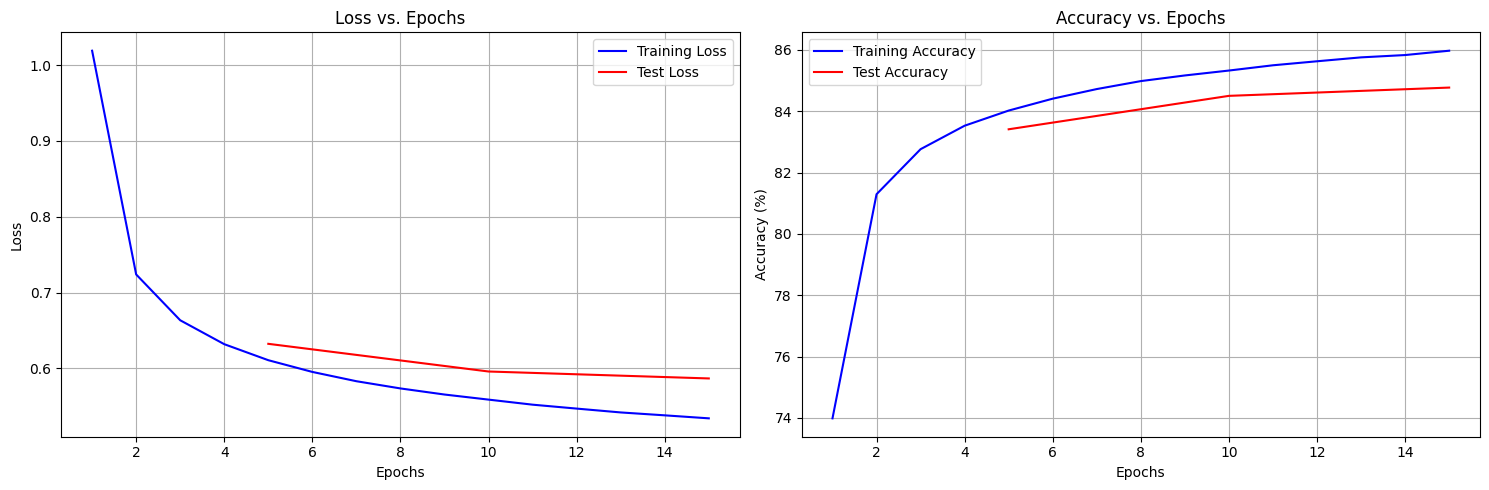

In [53]:
generate_training_graphs()

In [54]:
def generate_confusion_matrix(all_preds, all_targets):
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Plot full confusion matrix (might be too large to visualize well)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=out_classes, yticklabels=out_classes)
    plt.title('Confusion Matrix (All Classes)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_full.png')
    plt.close()

    # Plot confusion matrix for a subset of classes
    top_n = 15  # Show top 15 classes
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:top_n, :top_n], annot=True, fmt='d', cmap='Blues',
                xticklabels=out_classes[:top_n], yticklabels=out_classes[:top_n])
    plt.title(f'Confusion Matrix (Top {top_n} Classes)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_subset.png')
    plt.show()

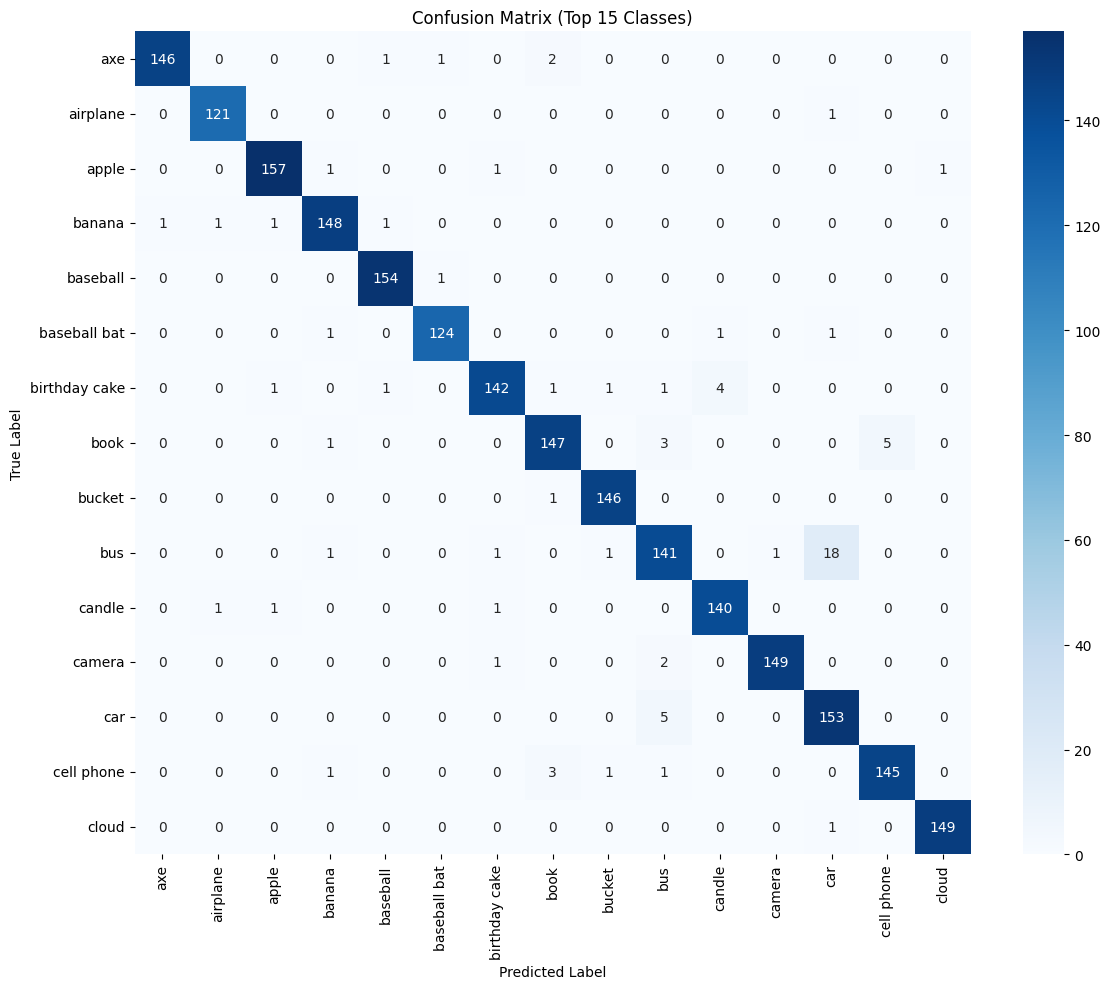

In [56]:
generate_confusion_matrix(all_preds, all_targets)

In [42]:
def generate_classification_report(all_preds, all_targets):
    # Generate classification report
    report = classification_report(all_targets, all_preds, target_names=out_classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Print the report
    print("Classification Report:")
    print(pd.DataFrame(report).transpose().round(3))

    # Save the report to CSV
    report_df.to_csv('classification_report.csv')

    # Plot precision, recall, and f1-score for each class
    plt.figure(figsize=(15, 10))

    # Extract class metrics
    class_metrics = report_df.iloc[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

    # Sort by F1-score
    class_metrics = class_metrics.sort_values(by='f1-score', ascending=False)

    # Plot as a bar chart
    class_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 10))
    plt.title('Precision, Recall, and F1-Score by Class (Sorted by F1-Score)')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('class_metrics.png')
    plt.show()

    # Find the top and worst performing classes
    top_classes = class_metrics.head(5).index.tolist()
    worst_classes = class_metrics.tail(5).index.tolist()

    print("\nTop 5 Best Performing Classes:")
    print(class_metrics.head(5))

    print("\nTop 5 Worst Performing Classes:")
    print(class_metrics.tail(5))

    return top_classes, worst_classes

Classification Report:
              precision  recall  f1-score    support
axe               0.854   0.816     0.834    179.000
airplane          0.669   0.877     0.759    138.000
apple             0.935   0.924     0.929    170.000
banana            0.813   0.925     0.865    160.000
baseball          0.890   0.933     0.911    165.000
...                 ...     ...       ...        ...
wine glass        0.931   0.865     0.897    171.000
zigzag            0.790   0.875     0.830    176.000
accuracy          0.848   0.848     0.848      0.848
macro avg         0.852   0.849     0.849  10000.000
weighted avg      0.852   0.848     0.848  10000.000

[63 rows x 4 columns]


<Figure size 1500x1000 with 0 Axes>

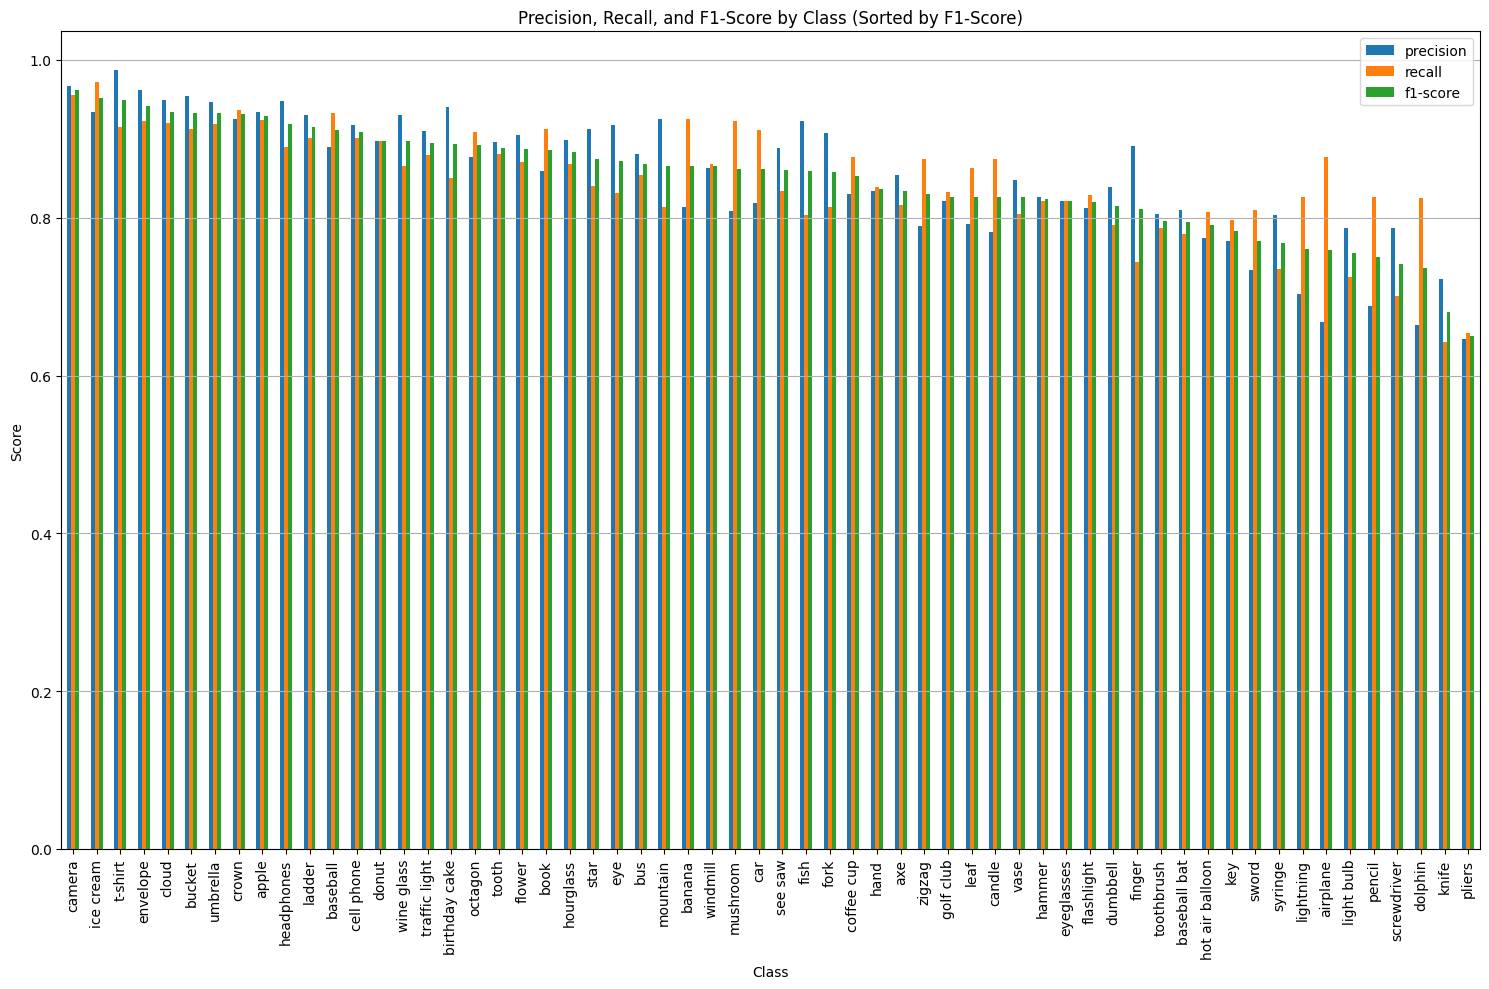


Top 5 Best Performing Classes:
           precision    recall  f1-score  support
camera      0.967532  0.955128  0.961290    156.0
ice cream   0.934066  0.971429  0.952381    175.0
t-shirt     0.986928  0.915152  0.949686    165.0
envelope    0.962500  0.922156  0.941896    167.0
cloud       0.949045  0.919753  0.934169    162.0

Top 5 Worst Performing Classes:
             precision    recall  f1-score  support
pencil        0.688172  0.825806  0.750733    155.0
screwdriver   0.787097  0.701149  0.741641    174.0
dolphin       0.663830  0.825397  0.735849    189.0
knife         0.722222  0.642857  0.680233    182.0
pliers        0.646739  0.653846  0.650273    182.0


In [66]:
top_classes, worst_classes = generate_classification_report(all_preds, all_targets)

In [58]:
def visualize_predictions():
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

    # Plot images with true and predicted labels
    plt.figure(figsize=(20, 10))
    for i in range(20):  # Show 20 examples
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].squeeze().cpu().numpy(), cmap='gray_r')
        true_label = out_classes[labels[i]]
        pred_label = out_classes[preds[i].cpu().numpy()]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()


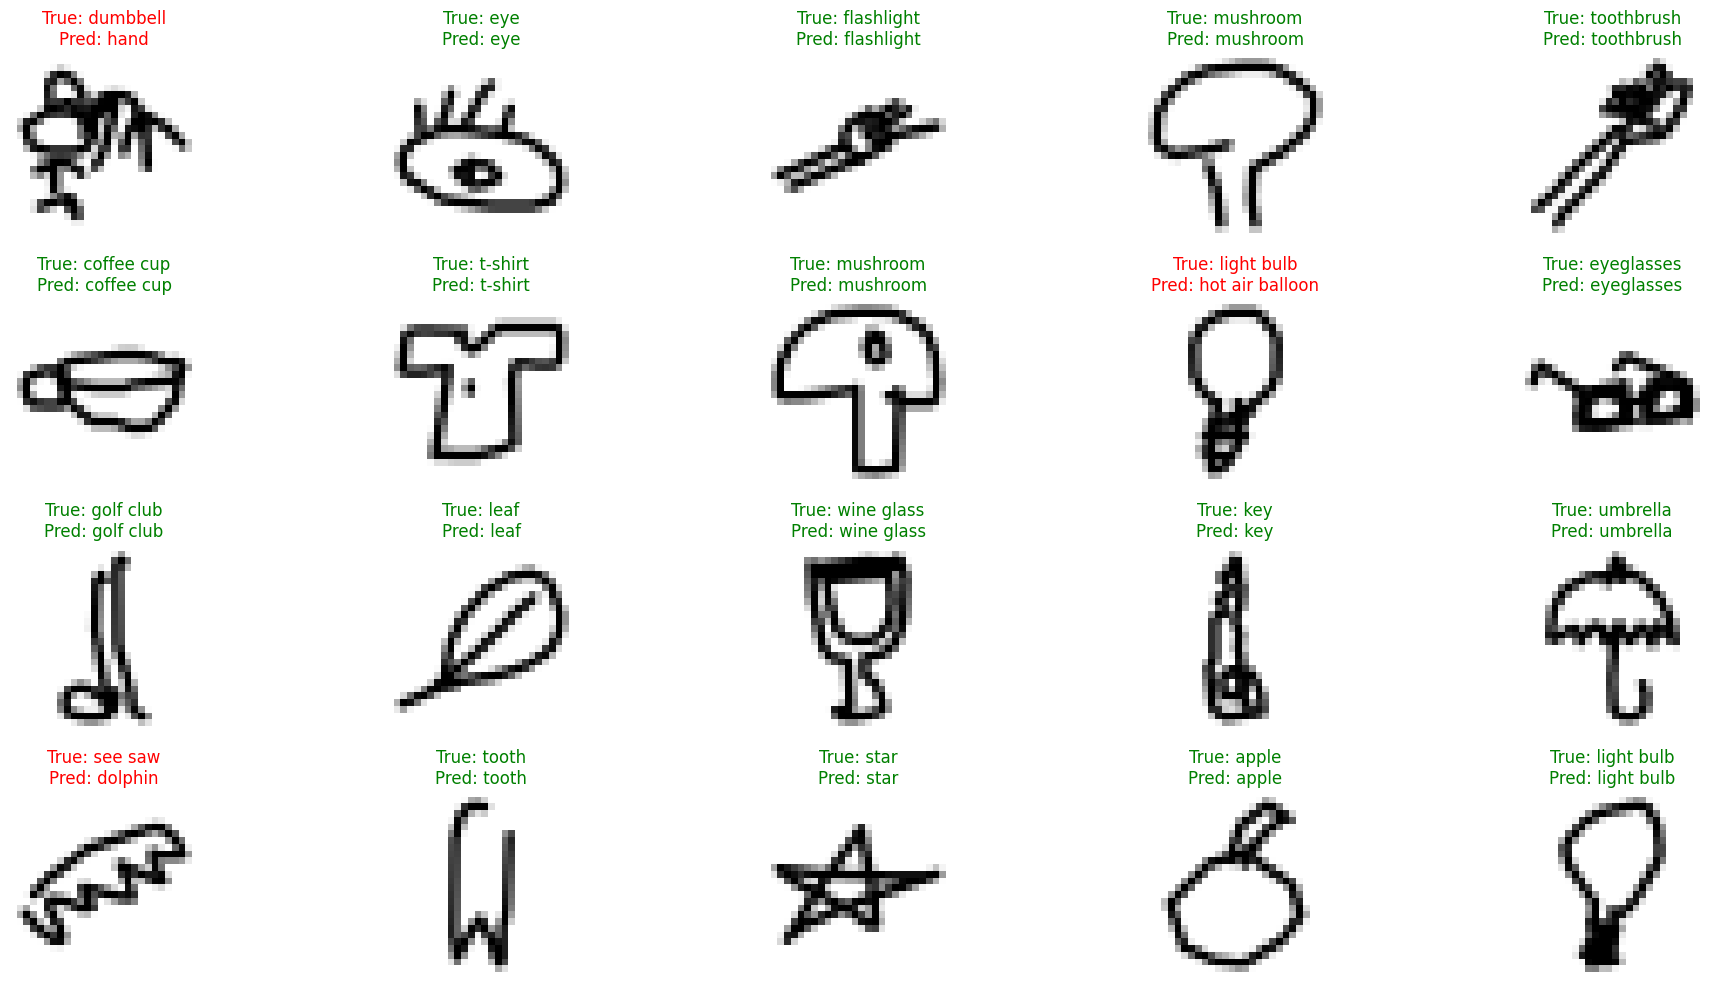

In [59]:
visualize_predictions()

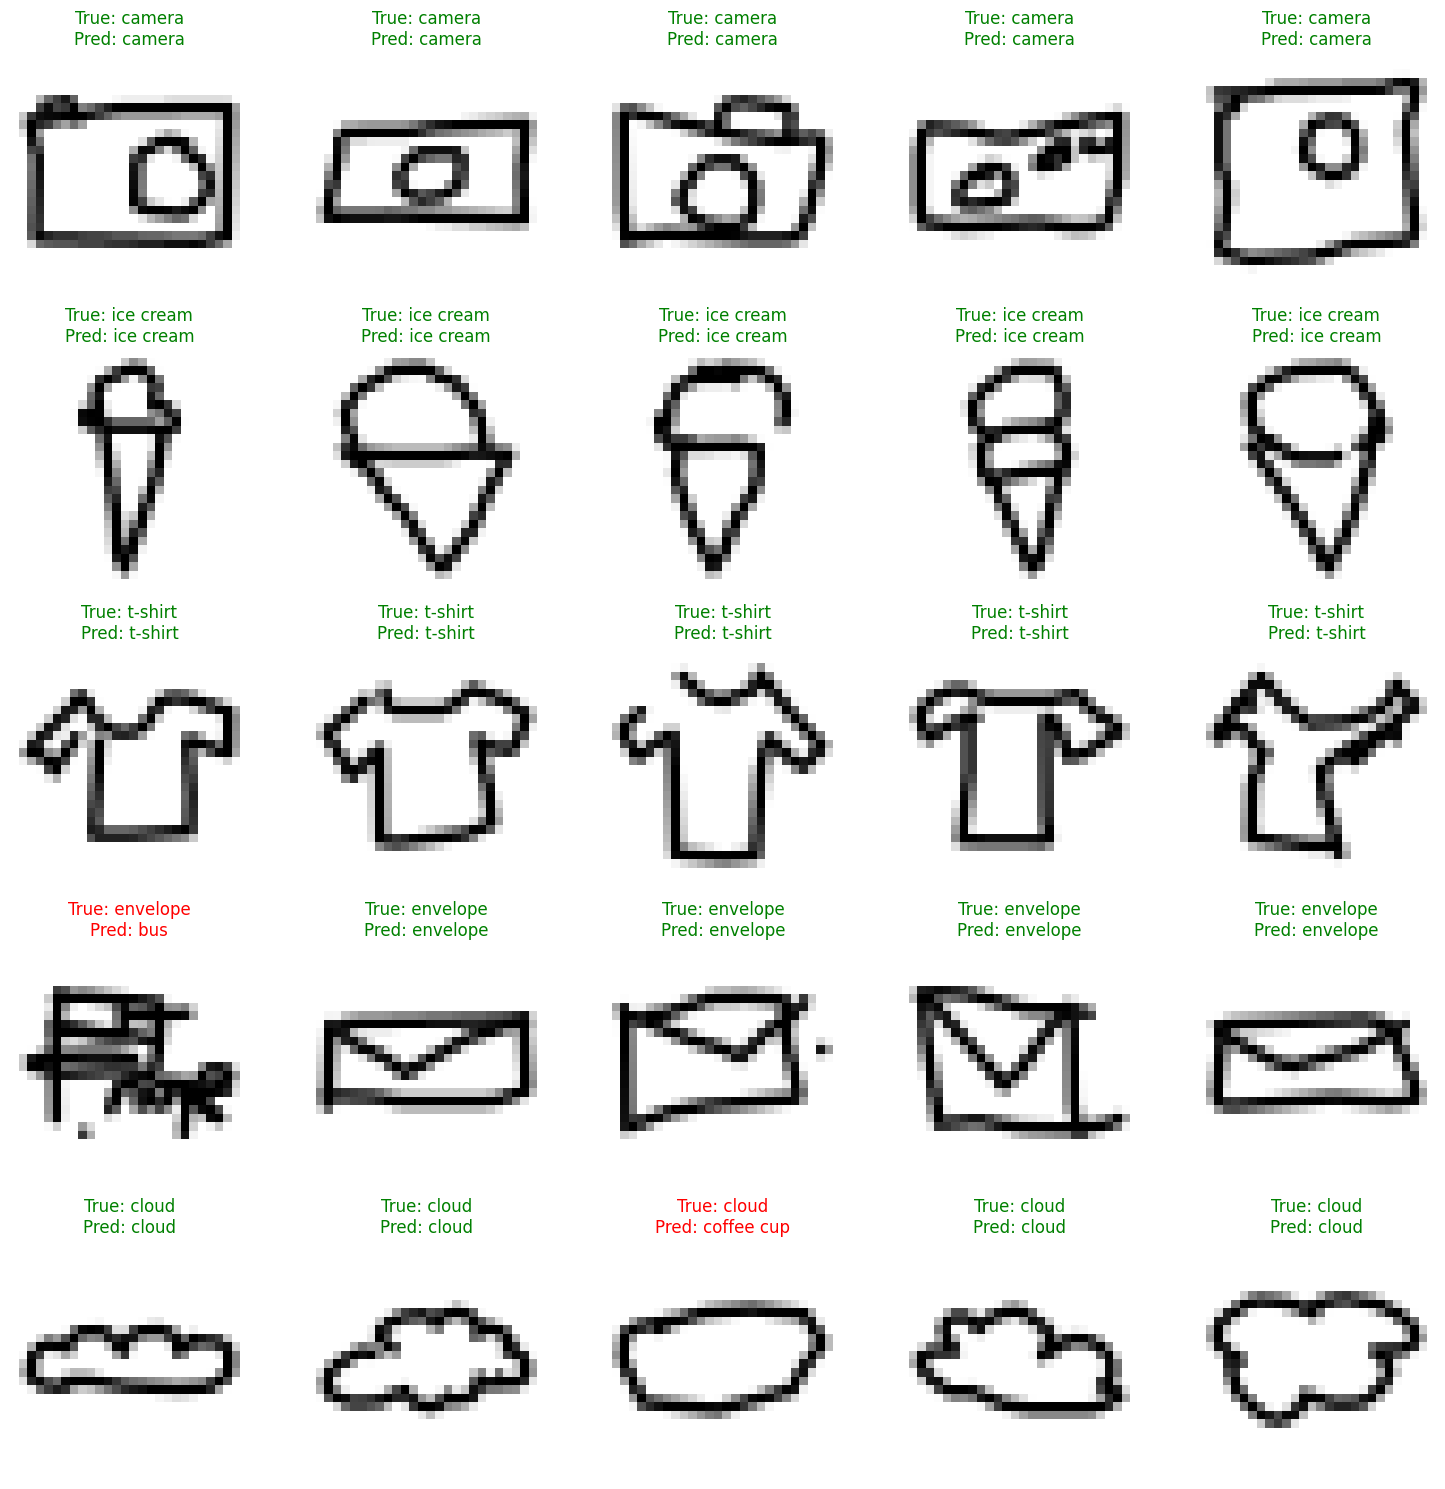

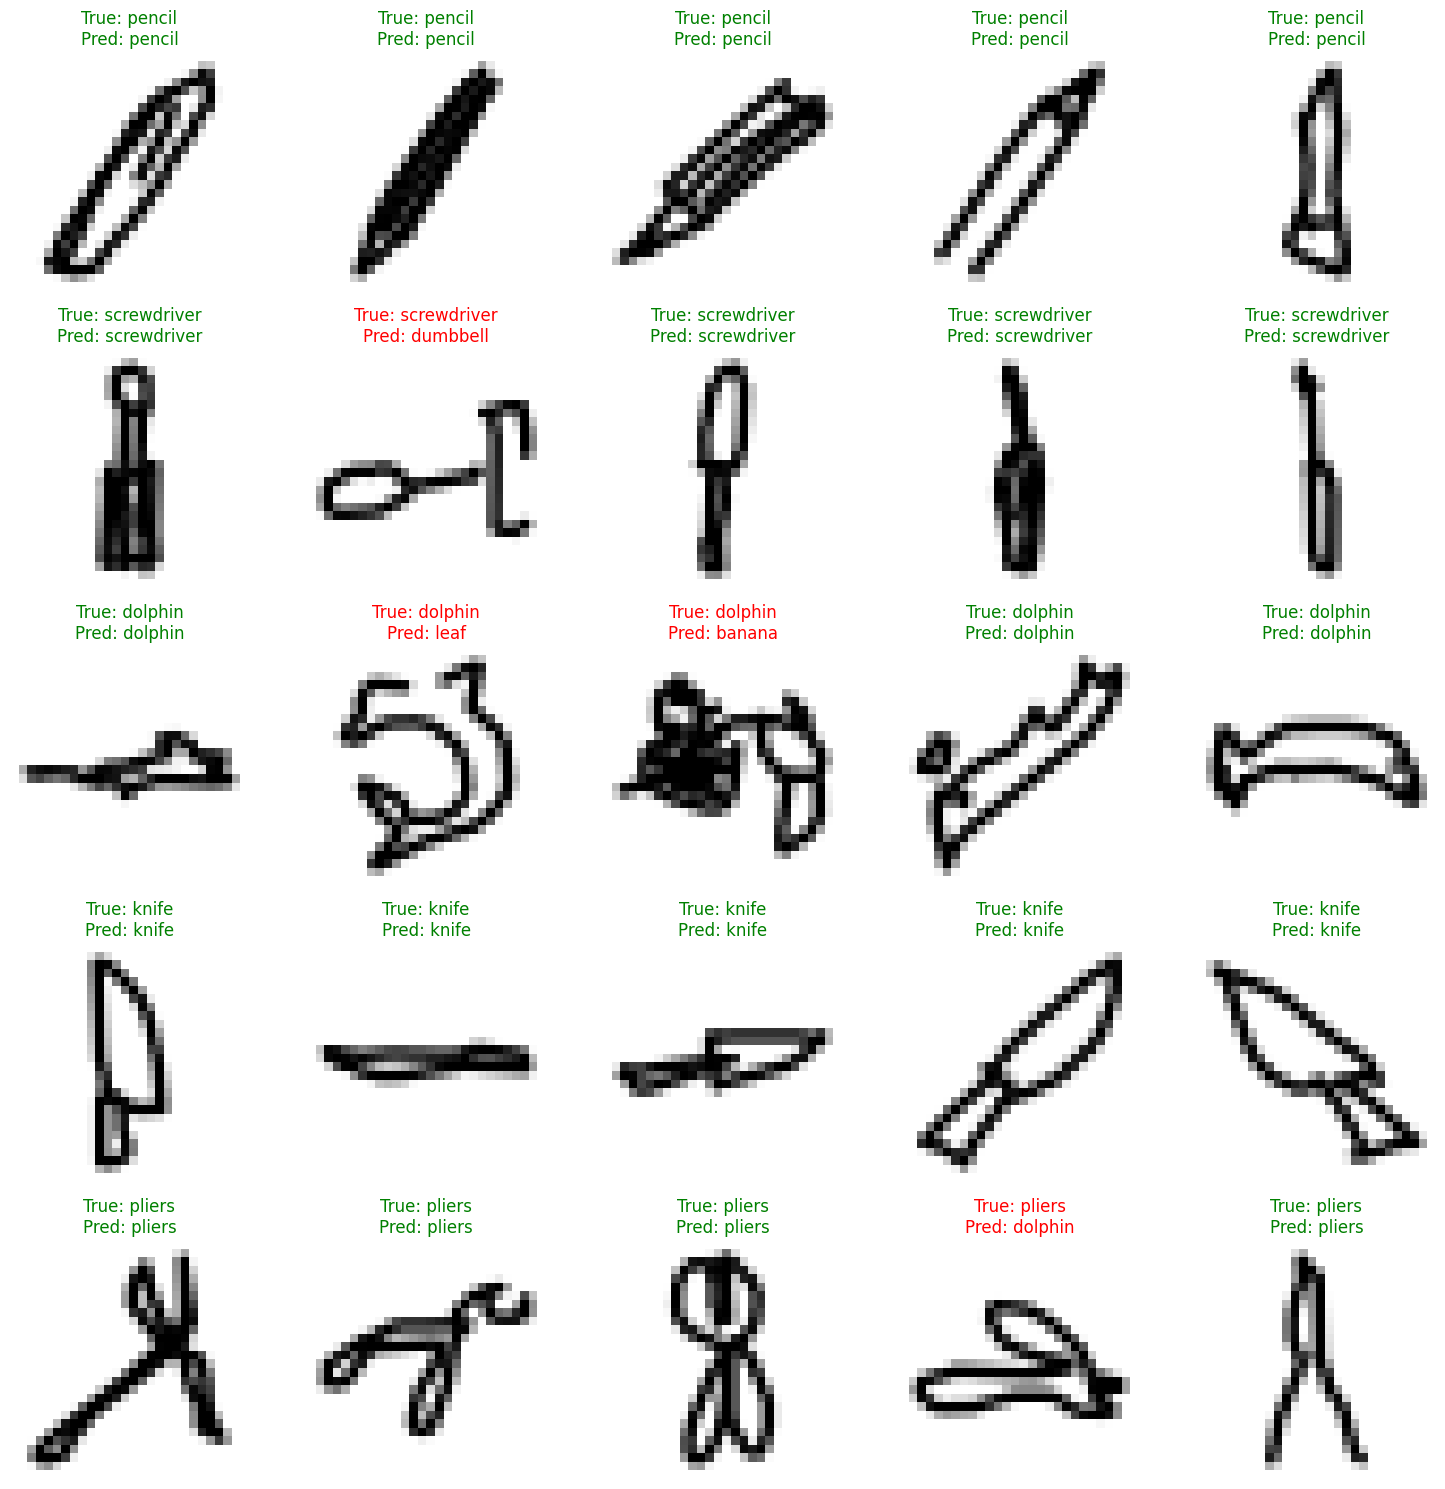

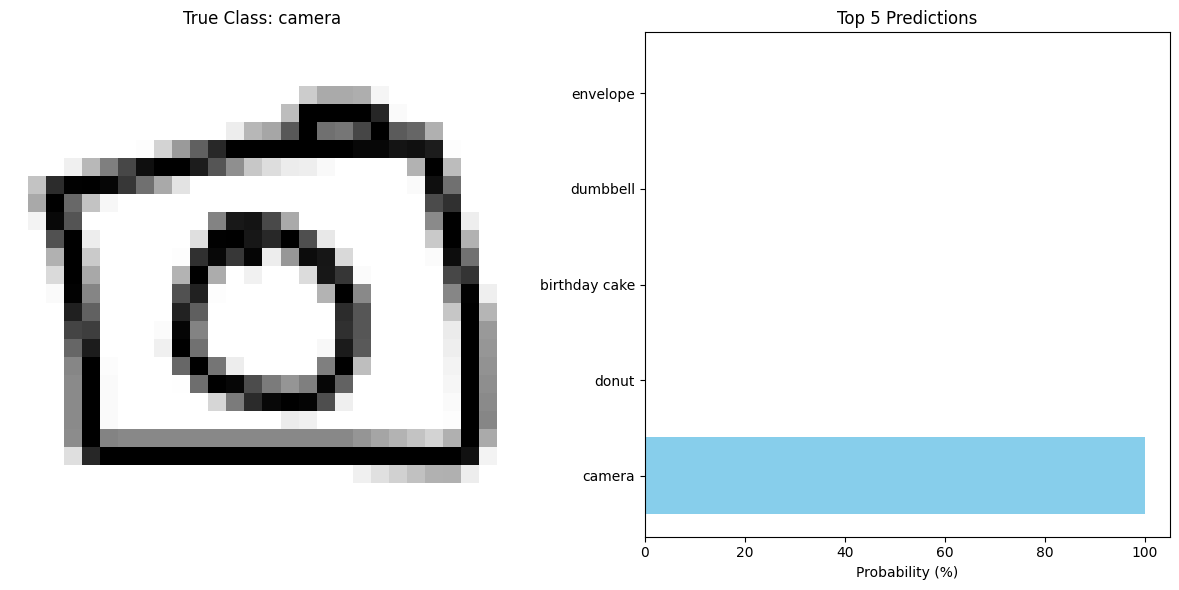

True class: camera

Top 5 predictions:
camera: 100.00%
donut: 0.00%
birthday cake: 0.00%
dumbbell: 0.00%
envelope: 0.00%

Model Architecture:
DoodleClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=60, bias=True)
)

Total parameters: 66000
Training time: 728.37 seconds
Final training accuracy: 85.97%
Final test accuracy: 84.77%


In [71]:
def generate_class_examples(classes_to_show):
    model.eval()
    plt.figure(figsize=(15, len(classes_to_show) * 3))

    for idx, class_name in enumerate(classes_to_show):
        class_idx = out_classes.index(class_name)

        # Find examples of this class in the test set
        class_indices = np.where(Y_test == class_idx)[0]
        if len(class_indices) == 0:
            continue

        # Select 5 random examples
        sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)

        for i, sample_idx in enumerate(sample_indices):
            # Get the image and convert to float32 with shape (1, 1, 28, 28)
            img = torch.tensor(X_test[sample_idx].reshape(1, 1, 28, 28), dtype=torch.float32).to(device) / 255.0

            # Get prediction
            with torch.no_grad():
                output = model(img)
                _, pred = output.max(1)
                pred_class = out_classes[pred.item()]

            # Plot the image
            plt.subplot(len(classes_to_show), 5, idx * 5 + i + 1)
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
            color = 'green' if pred_class == class_name else 'red'
            plt.title(f"True: {class_name}\nPred: {pred_class}", color=color)
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('class_examples.png')
    plt.show()

def predict_single_image(index):
    """Make a prediction on a single image and show detailed probabilities"""
    model.eval()

    # Get image with shape (1, 1, 28, 28)
    img = torch.tensor(X_test[index].reshape(1, 1, 28, 28), dtype=torch.float32).to(device) / 255.0

    # Get prediction
    with torch.no_grad():
        output = model(img)
        probabilities = F.softmax(output, dim=1)[0]

    # Get top 5 predictions
    values, indices = torch.topk(probabilities, 5)

    # Plot the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    plt.title(f"True Class: {out_classes[int(Y_test[index])]}")
    plt.axis('off')

    # Plot the probabilities
    plt.subplot(1, 2, 2)
    classes = [out_classes[idx] for idx in indices.cpu().numpy()]
    values = values.cpu().numpy() * 100  # Convert to percentage

    # Create horizontal bar chart
    plt.barh(range(len(classes)), values, color='skyblue')
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Probability (%)')
    plt.title('Top 5 Predictions')
    plt.tight_layout()
    plt.savefig('single_prediction.png')
    plt.show()

    # Print detailed information
    print(f"True class: {out_classes[int(Y_test[index])]}")
    print("\nTop 5 predictions:")
    for i in range(len(classes)):
        print(f"{classes[i]}: {values[i]:.2f}%")

# Generate model summary
def generate_model_summary():
    print("\nModel Architecture:")
    print(model)
    print(f"\nTotal parameters: {count_parameters(model)}")
    print(f"Training time: {elapsed_time:.2f} seconds")
    print(f"Final training accuracy: {train_accs[-1]:.2f}%")
    print(f"Final test accuracy: {test_acc:.2f}%")

# Call the functions
generate_class_examples(top_classes)
generate_class_examples(worst_classes)
predict_single_image(784)
generate_model_summary()


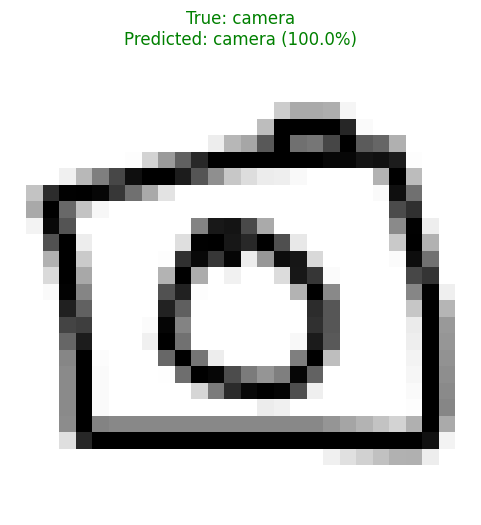

Top 3 predictions:
camera: 100.00%
donut: 0.00%
birthday cake: 0.00%


In [73]:
def draw_and_predict(index):
    """Display an image and make a prediction"""
    img = X_test[index].reshape(28, 28)
    img_tensor = torch.tensor(img.reshape(1, 1, 28, 28) / 255.0, dtype=torch.float32).to(device)

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray_r')

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
        _, predicted = torch.max(outputs, 1)

    true_class = out_classes[int(Y_test[index])]
    pred_class = out_classes[predicted.item()]

    # Get top 3 predictions
    values, indices = torch.topk(probabilities, 3)
    top3_classes = [out_classes[idx] for idx in indices.cpu().numpy()]
    top3_probs = values.cpu().numpy() * 100

    plt.title(f"True: {true_class}\nPredicted: {pred_class} ({top3_probs[0]:.1f}%)",
              color='green' if true_class == pred_class else 'red')
    plt.axis('off')
    plt.show()

    print(f"Top 3 predictions:")
    for i in range(3):
        print(f"{top3_classes[i]}: {top3_probs[i]:.2f}%")
draw_and_predict(784)

In [47]:
!zip -r dataset.zip dataset/

  adding: dataset/ (stored 0%)
  adding: dataset/candle.npy (deflated 75%)
  adding: dataset/bucket.npy (deflated 64%)
  adding: dataset/key.npy (deflated 72%)
  adding: dataset/camera.npy (deflated 63%)
  adding: dataset/cell phone.npy (deflated 61%)
  adding: dataset/flashlight.npy (deflated 72%)
  adding: dataset/eye.npy (deflated 67%)
  adding: dataset/traffic light.npy (deflated 66%)
  adding: dataset/fish.npy (deflated 69%)
  adding: dataset/ice cream.npy (deflated 68%)
  adding: dataset/golf club.npy (deflated 78%)
  adding: dataset/hourglass.npy (deflated 65%)
  adding: dataset/baseball.npy (deflated 56%)
  adding: dataset/see saw.npy (deflated 78%)
  adding: dataset/star.npy (deflated 64%)
  adding: dataset/donut.npy (deflated 56%)
  adding: dataset/screwdriver.npy (deflated 78%)
  adding: dataset/coffee cup.npy (deflated 63%)
  adding: dataset/light bulb.npy (deflated 67%)
  adding: dataset/pliers.npy (deflated 67%)
  adding: dataset/wine glass.npy (deflated 70%)
  adding: da